In [99]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def threshold_by_contour_count(contour_count):
    if contour_count <= 50:
        return 500
    elif contour_count <= 100:
        return 1000
    elif contour_count <= 500:
        return 5000
    elif contour_count <= 1000:
        return 7500
    else:
        return 10000

def detect_plant_rows_with_rectangles(image_path):
    # Bild laden
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # In HSV umwandeln
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Grünbereich definieren (anpassen je nach Bild)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Morphologische Filter (Rauschen entfernen)
    kernel = np.ones((5,5), np.uint8)
    mask_clean = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # Konturen finden
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Anzahl gefundener Konturen: {len(contours)}")

    # Threshhold dynamisch, abhängig von Anzahl gefundener Konturen setzen
    threshhold = threshold_by_contour_count(len(contours))

    # Bild kopieren, um Rechtecke zu zeichnen
    img_rects = img_rgb.copy()

    # Mittelpunkte werden zurückgegeben
    circles = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        
        # wir berücksichtigen nur entsprechend große Konturen
        if area > threshhold:  
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius))
            print(f"Kreis Werte: Mittelpunkt: {center}, Radius: {radius}")
            cv2.circle(img_rects, center, radius, (0, 0, 255), 5)

    # Ergebnisse anzeigen
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Grün Maske")
    plt.imshow(mask_clean, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Erkannte Pflanzen")
    plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

    return circles

Anzahl gefundener Konturen: 1042
Kreis Werte: Mittelpunkt: (1439, 3939), Radius: 115
Kreis Werte: Mittelpunkt: (1365, 3524), Radius: 147
Kreis Werte: Mittelpunkt: (1337, 2945), Radius: 227
Kreis Werte: Mittelpunkt: (1331, 2413), Radius: 230
Kreis Werte: Mittelpunkt: (1404, 1455), Radius: 366
Kreis Werte: Mittelpunkt: (1381, 367), Radius: 257
Kreis Werte: Mittelpunkt: (1179, 96), Radius: 166


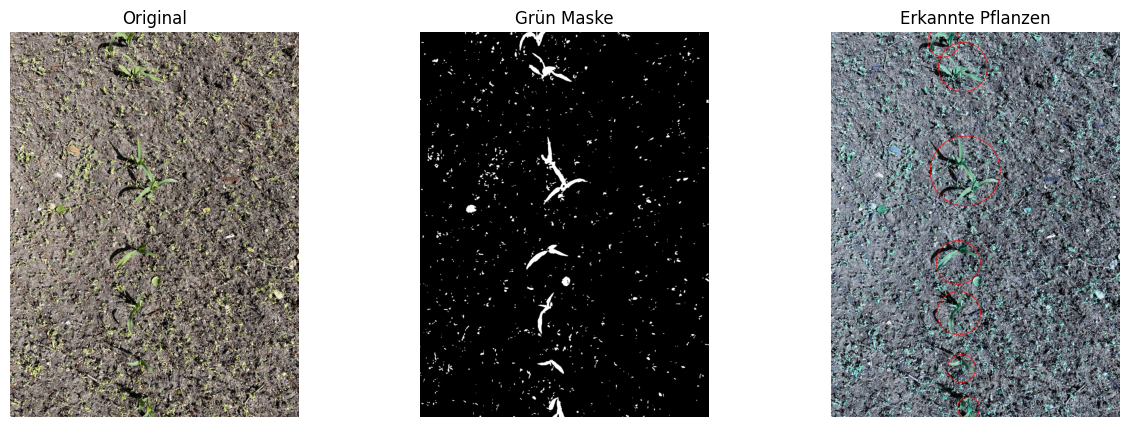

-1

In [100]:
# Kreise (oder ggf. Ellipsen) finden, die von Linie getroffen werden -> Bereiche müssen blockiert werden
# alle anderen müssen kaputt gemacht werden

img_path = '2_dataset/images/corn/IMG_4044.png'

# Parameter Hough-Transformation
minLineLength = 100
threshholdHoughLines = 2
maxLineGap = 2000

# Parameter Filterung
minAngle = 85
maxAngle = 95
lineArea = 300

# Grüne Konturen finden und Mittelpunkte bestimmen
circles = detect_plant_rows_with_rectangles(img_path)

imgOutput = cv2.imread(img_path)
height, width = imgOutput.shape[:2]
x_center = width // 2

# Leeres Bild erstellen
imgHoughTransformation = np.zeros((height, width), dtype=np.uint8)

# Punkte einzeichnen
for circle in circles:
    cv2.circle(imgHoughTransformation, circle[0], radius=10, color=255, thickness=-1)
    cv2.circle(imgOutput, circle[0], radius=circle[1], color=(0, 0, 255), thickness=5)


# Hough-Linien-Transformation anwenden
linien = cv2.HoughLinesP(imgHoughTransformation, rho=1, theta=np.pi/180, threshold=threshholdHoughLines, minLineLength=minLineLength, maxLineGap=maxLineGap)

# Linien visualisieren
if linien is not None:
    for linie in linien:
        x1, y1, x2, y2 = linie[0]
        dx = x2 - x1
        dy = y2 - y1
        theta = np.arctan2(dy, dx)  # Winkel der Linie in Bogenmaß

        angle_deg = abs(np.degrees(theta))  # nur positiver Winkel

        # Normiere auf Bereich [0°, 180°]
        if angle_deg > 180:
            angle_deg -= 180

        # Nur annähernd senkrecht
        if minAngle <= angle_deg <= maxAngle:
            x_mean = (x1 + x2) / 2

            # Nur Linien nahe der Bildmitte 
            if abs(x_mean - x_center) <= lineArea:
                cv2.line(imgOutput, (x1, y1), (x2, y2), (0, 0, 255), 10)

# Bild kleiner skalieren
imgOutput = cv2.resize(imgOutput, None, fx = 0.15, fy = 0.15)
cv2.imshow('Linien', imgOutput)
cv2.waitKey(0)